# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
(validation_images, validation_labels) = (train_images[50000:], train_labels[50000:])
(train_images, train_labels) = (train_images[:50000], train_labels[:50000])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
with tf.device('CPU:0'):
    train_images_expanded = np.expand_dims(train_images, axis = 3)
    validation_images_expanded = np.expand_dims(validation_images, axis = 3)
    test_images_expanded = np.expand_dims(test_images, axis = 3)
    train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
    validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [6]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    history = model_name.fit(
    ti, tl,
    epochs = epochs,
    validation_data = (vi, vl))
    model_name.summary()
    return history
def write_to_json(dictionary, gmean, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [7]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 159us/sample - loss: 0.4124 - acc: 0.8796 - val_loss: 0.1365 - val_acc: 0.9631
Epoch 2/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.1110 - acc: 0.9665 - val_loss: 0.0906 - val_acc: 0.9744
Epoch 3/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0792 - acc: 0.9757 - val_loss: 0.0679 - val_acc: 0.9798
Epoch 4/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0628 - acc: 0.9804 - val_loss: 0.0604 - val_acc: 0.9820
Epoch 5/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0524 - acc: 0.9838 - val_loss: 0.0552 - val_acc: 0.9831
Epoch 6/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0446 - acc: 0.9862 - val_loss: 0.0513 - val_acc: 0.9862
Epoch 7/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0391 - acc: 0.9875 - val_l

In [8]:
baseline_probab = tf.keras.models.Sequential([baseline, tf.keras.layers.Softmax()])
baseline_probab.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                197018    
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 197,018
Trainable params: 197,018
Non-trainable params: 0
_________________________________________________________________


In [9]:
history.history

{'loss': [0.41239148244738577,
  0.11096159209311009,
  0.07918752667799592,
  0.06278443777389825,
  0.052375315460264686,
  0.04455203339643776,
  0.03909943272102624,
  0.034220019450262186,
  0.030021430183630436,
  0.026763514050729572,
  0.02373583894053474,
  0.02111432562855072,
  0.018626756329627243,
  0.016670433388720266,
  0.014869403500291518,
  0.012920246352110407,
  0.011679549350326415,
  0.010646475399563787,
  0.00943450058366725,
  0.008287784824940027],
 'acc': [0.8796,
  0.96648,
  0.97574,
  0.98038,
  0.9838,
  0.98618,
  0.98748,
  0.98926,
  0.99062,
  0.99182,
  0.99244,
  0.99358,
  0.99426,
  0.9952,
  0.9952,
  0.99588,
  0.99644,
  0.99672,
  0.9971,
  0.99742],
 'val_loss': [0.13648085060566664,
  0.09060666612684727,
  0.06792783702202142,
  0.0604438874559477,
  0.05520005734749139,
  0.05127365681147203,
  0.043791746963420884,
  0.044134223939850926,
  0.04267282282919623,
  0.04154783497508615,
  0.037611742837599015,
  0.0399043566852808,
  0.0480

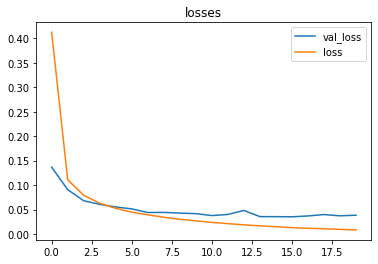

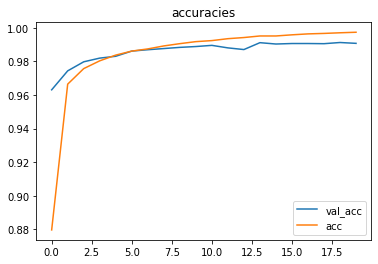

In [10]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [12]:
with tf.device('CPU:0'):    
    baseline_test_preds = tf.argmax(baseline_probab(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    print(baseline_gmean)

0.9892032903958768


In [ ]:
#write_to_json(history.history, baseline_gmean, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.1 \rho=100$

{0: 4506, 1: 4506, 2: 45, 3: 4506, 4: 4506, 5: 4506, 6: 4506, 7: 45, 8: 45, 9: 45}


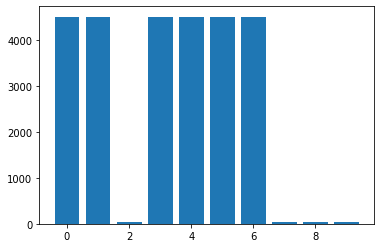

mu = 0.4, rho = 100.13333333333334


In [13]:
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, train_labels, 0.4, 100)
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0

### check model behavior on imbalanced set

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [15]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, imb_train_images_tf, imb_train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 27216 samples, validate on 10000 samples
Epoch 1/20
27216/27216 [==============================] - 4s 156us/sample - loss: 0.3868 - acc: 0.8975 - val_loss: 1.7775 - val_acc: 0.5902
Epoch 2/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0918 - acc: 0.9737 - val_loss: 0.9734 - val_acc: 0.6973
Epoch 3/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0588 - acc: 0.9819 - val_loss: 0.6460 - val_acc: 0.7733
Epoch 4/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0440 - acc: 0.9864 - val_loss: 0.6397 - val_acc: 0.7808
Epoch 5/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0360 - acc: 0.9880 - val_loss: 0.5048 - val_acc: 0.8421
Epoch 6/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0302 - acc: 0.9902 - val_loss: 0.4944 - val_acc: 0.8438
Epoch 7/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0261 - acc: 0.9915 - val_l

In [16]:
baseline_probab = tf.keras.models.Sequential([baseline, tf.keras.layers.Softmax()])
baseline_probab.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 10)                197018    
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 197,018
Trainable params: 197,018
Non-trainable params: 0
_________________________________________________________________


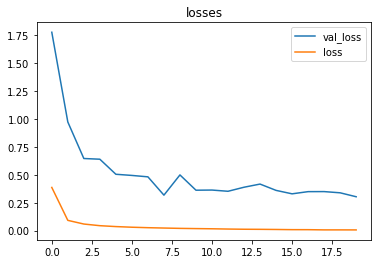

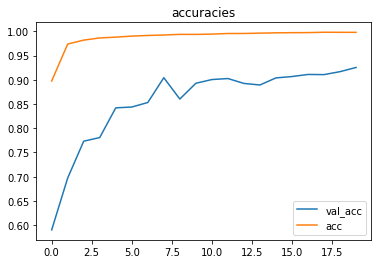

In [17]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [18]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline_probab(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    print(baseline_gmean)

0.9189903084622476


0


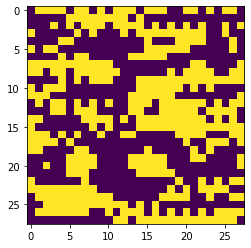

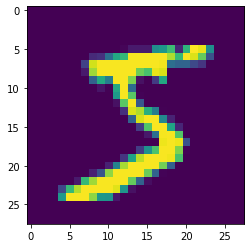

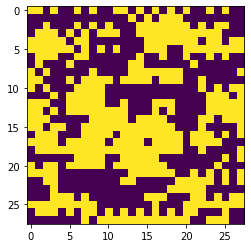

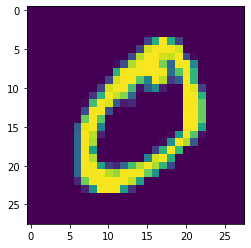

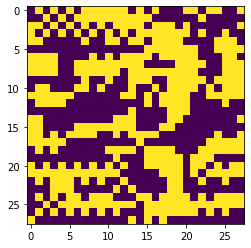

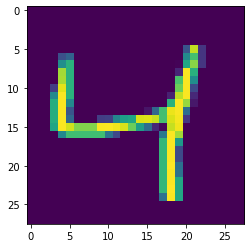

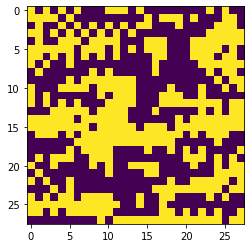

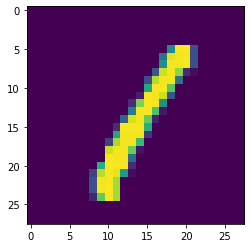

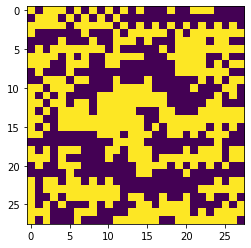

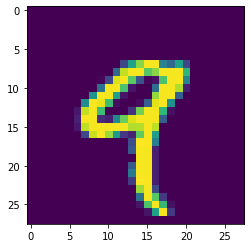

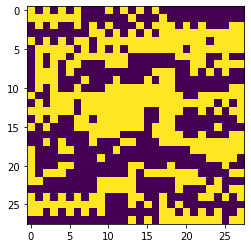

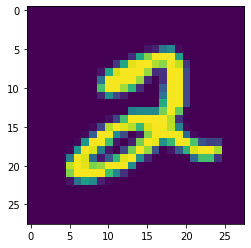

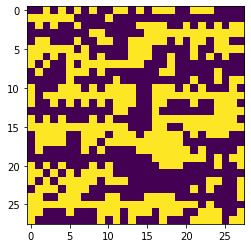

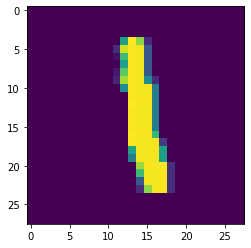

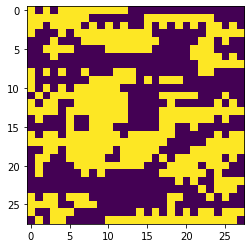

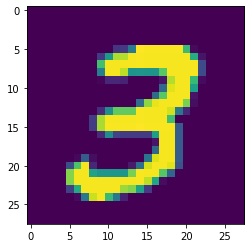

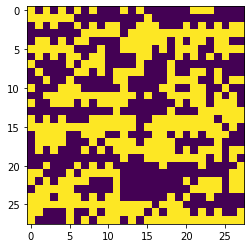

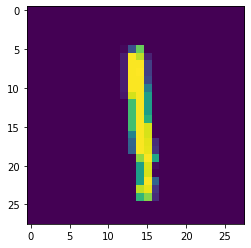

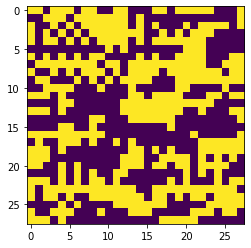

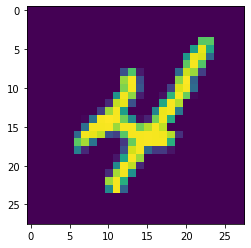

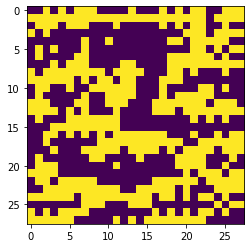

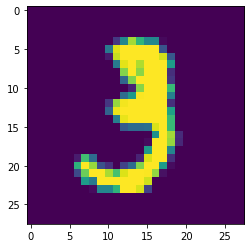

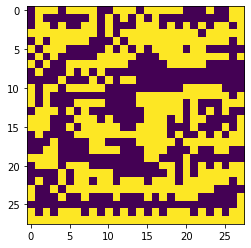

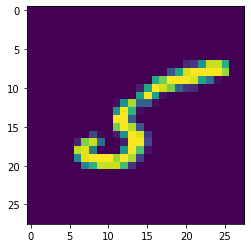

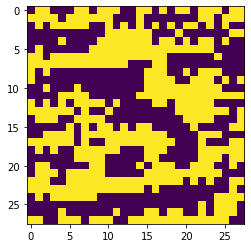

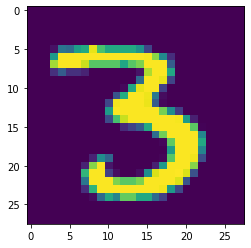

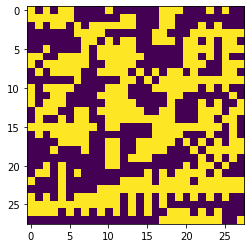

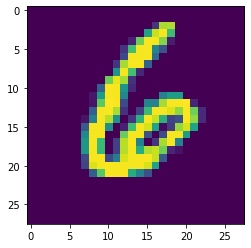

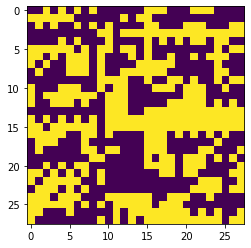

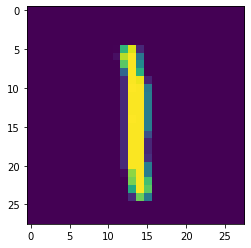

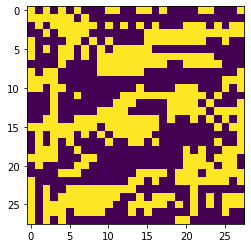

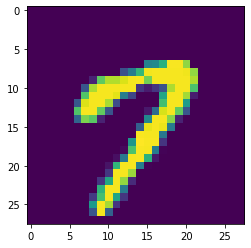

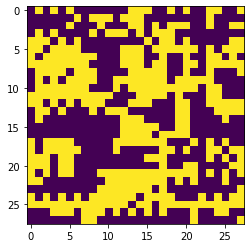

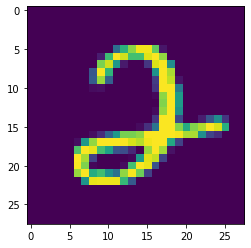

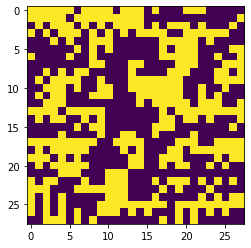

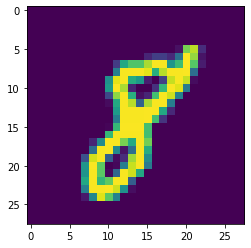

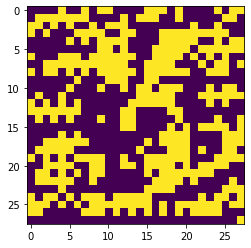

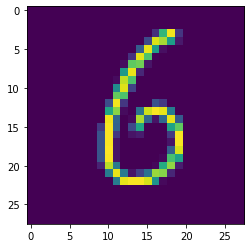

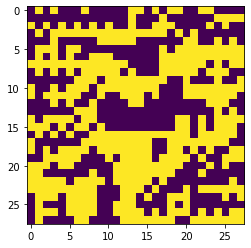

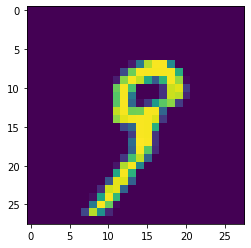

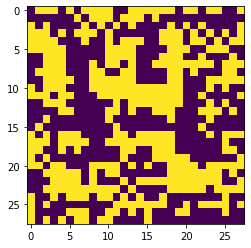

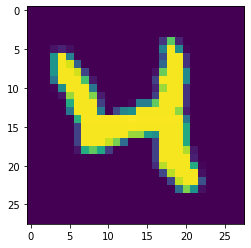

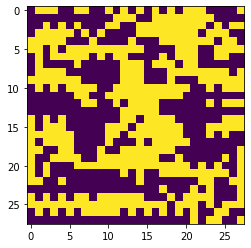

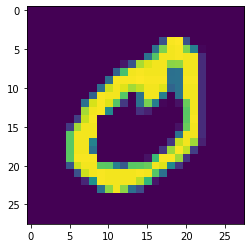

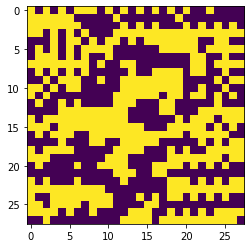

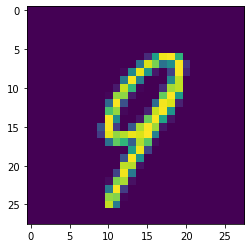

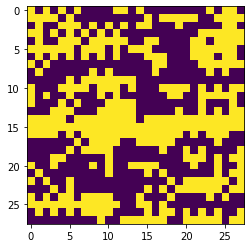

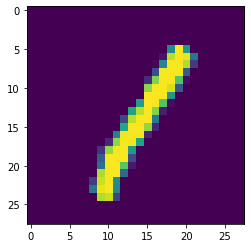

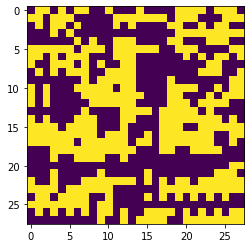

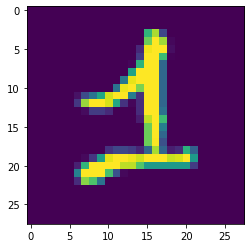

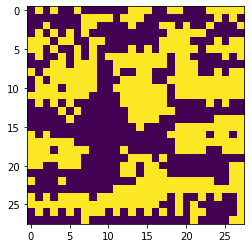

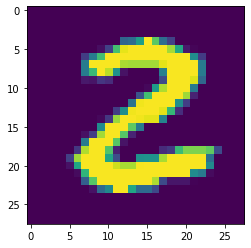

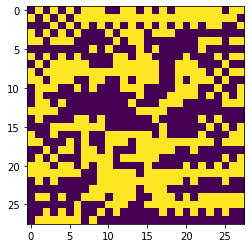

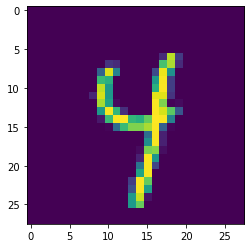

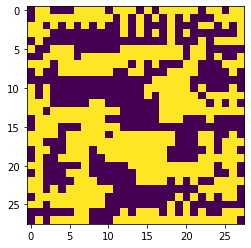

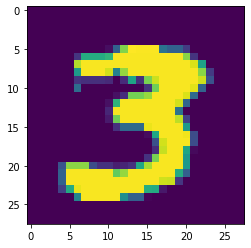

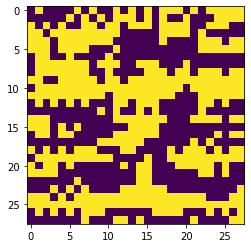

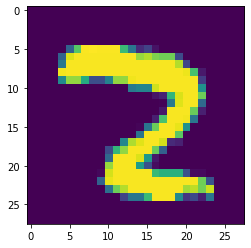

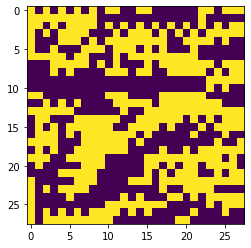

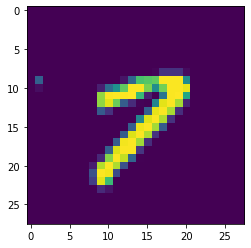

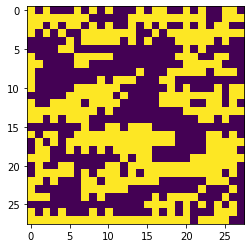

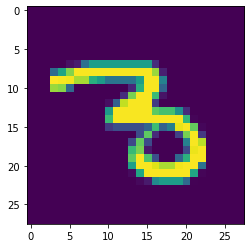

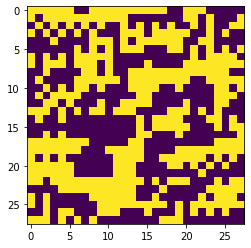

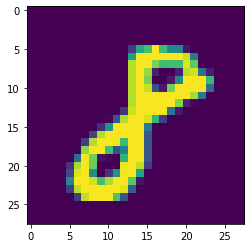

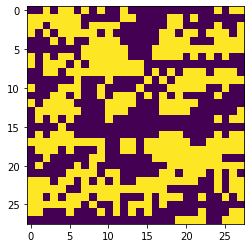

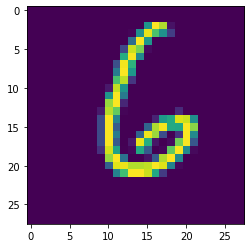

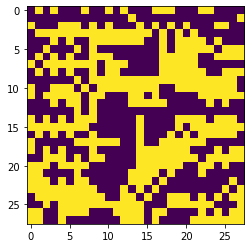

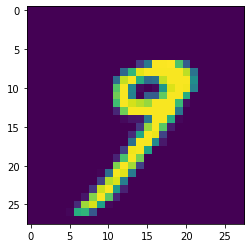

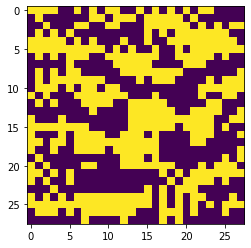

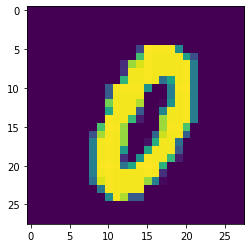

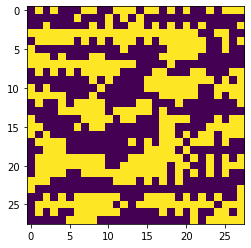

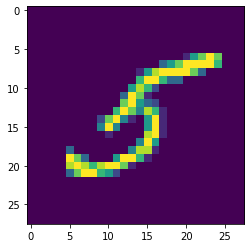

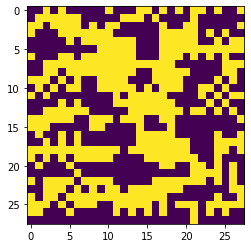

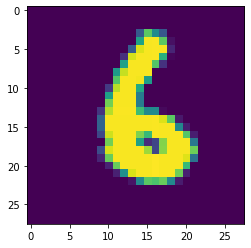

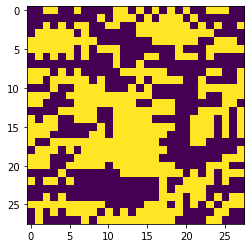

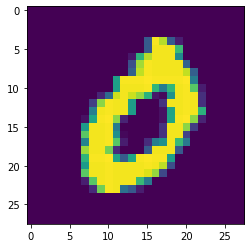

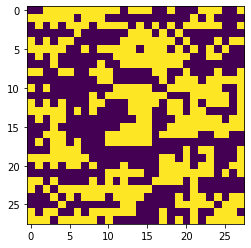

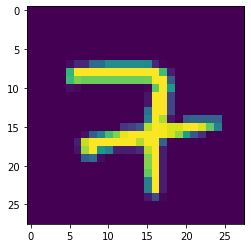

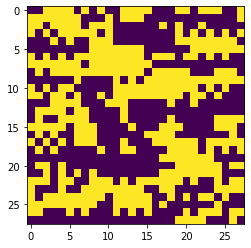

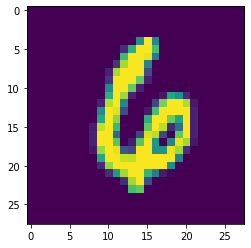

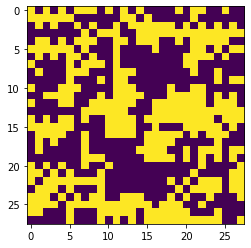

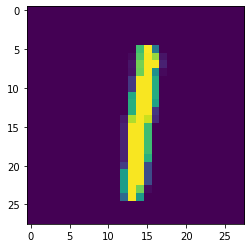

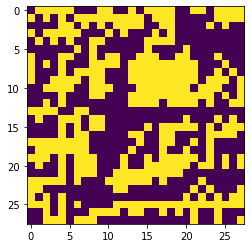

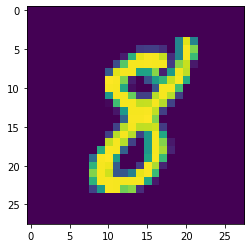

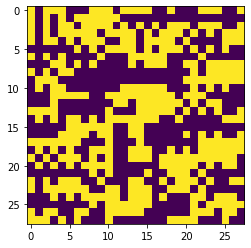

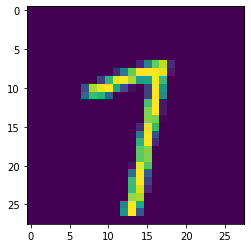

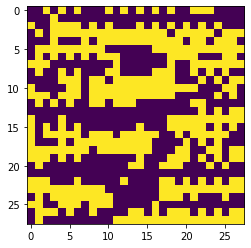

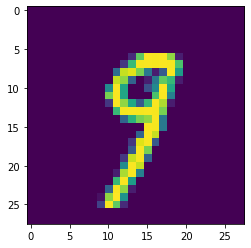

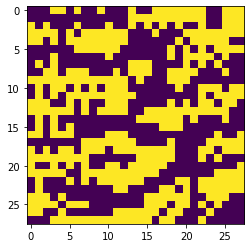

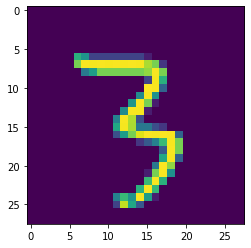

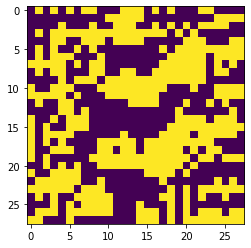

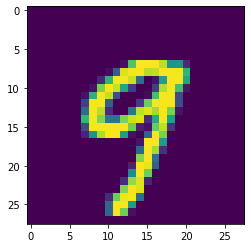

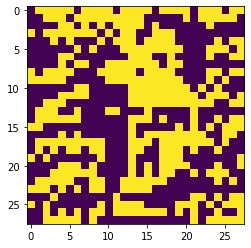

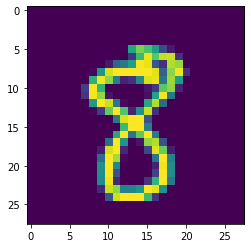

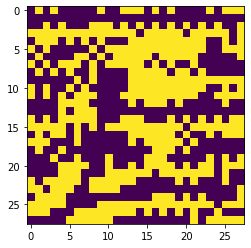

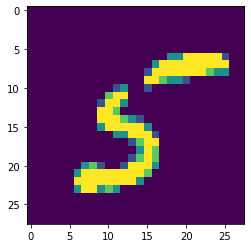

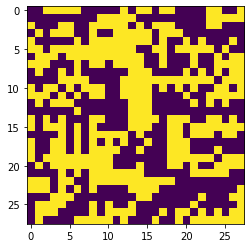

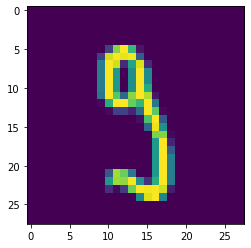

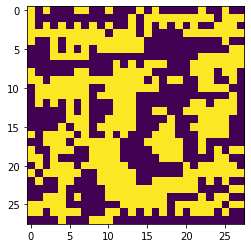

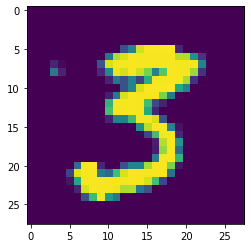

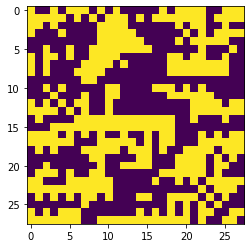

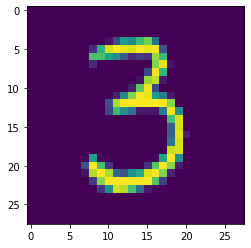

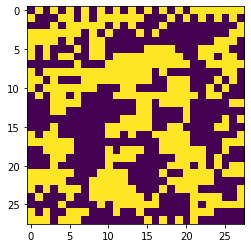

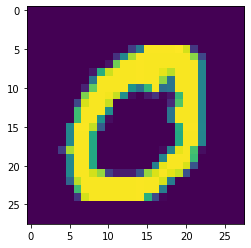

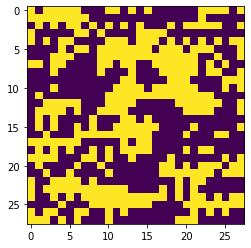

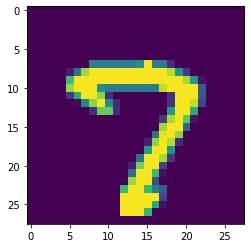

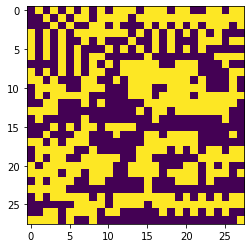

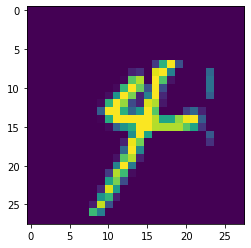

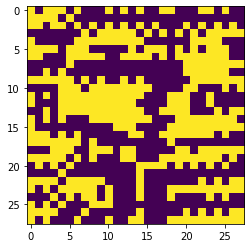

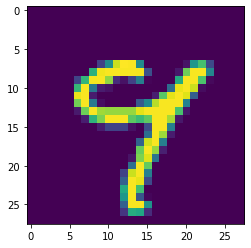

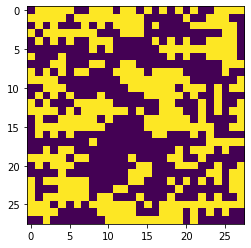

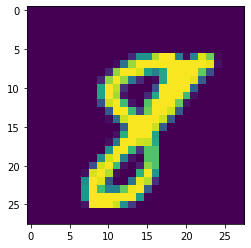

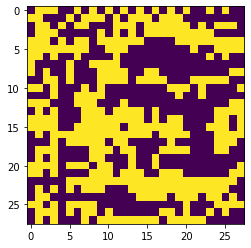

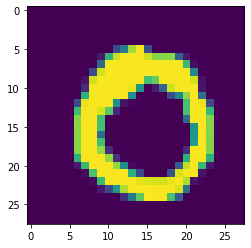

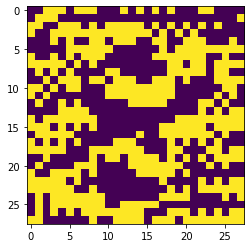

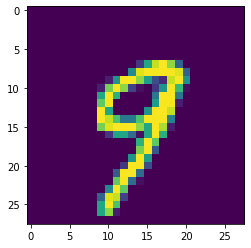

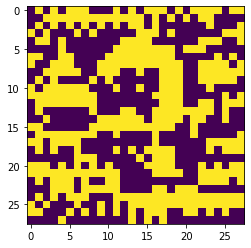

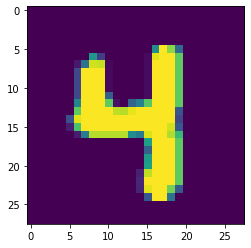

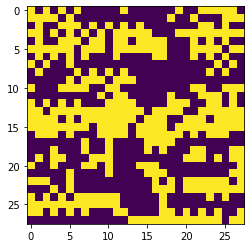

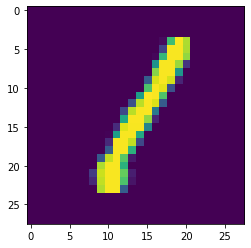

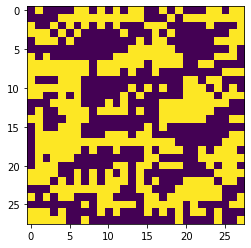

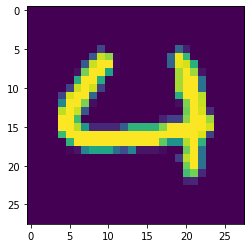

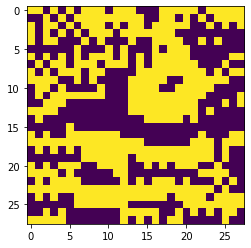

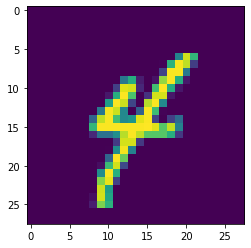

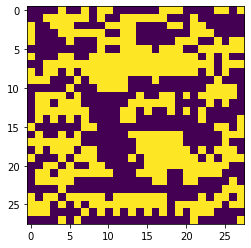

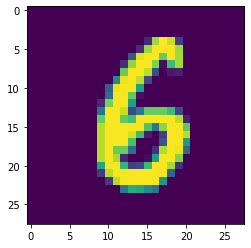

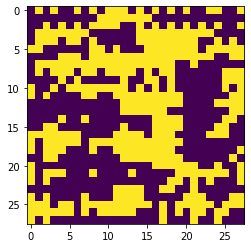

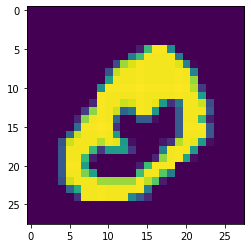

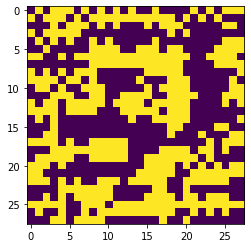

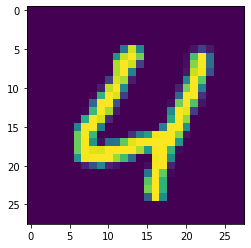

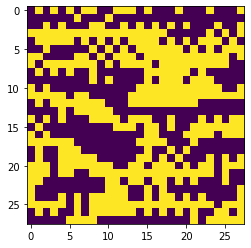

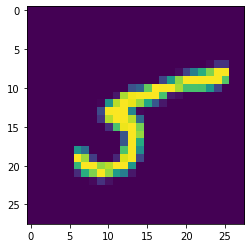

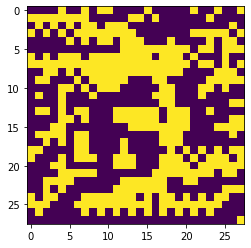

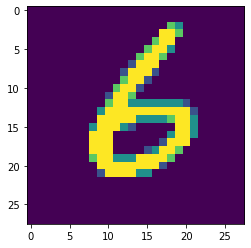

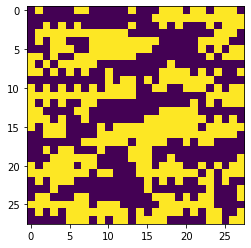

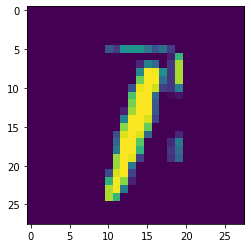

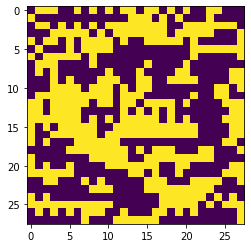

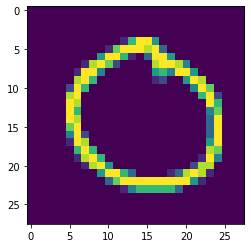

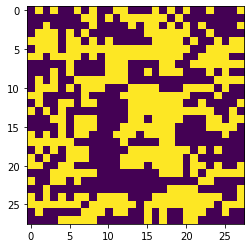

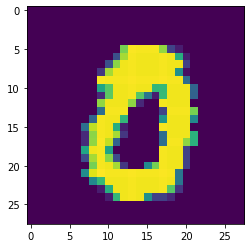

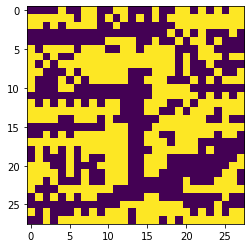

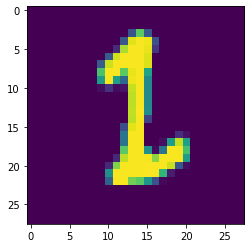

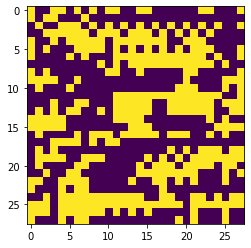

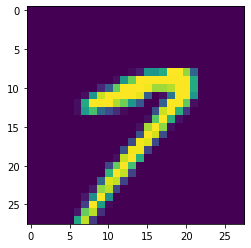

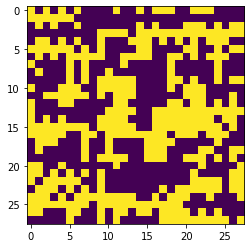

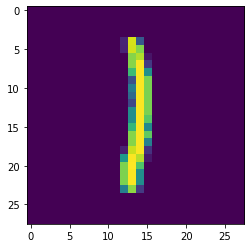

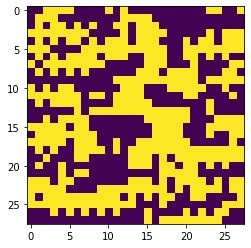

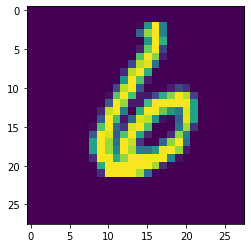

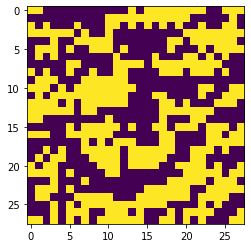

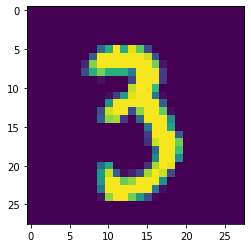

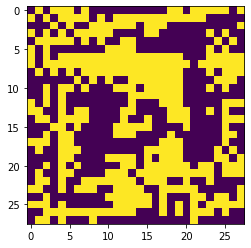

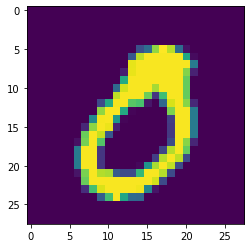

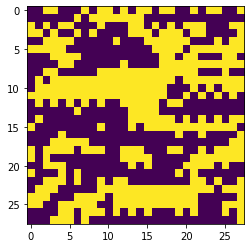

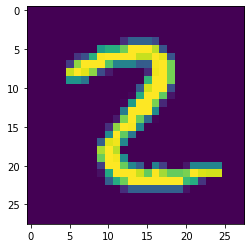

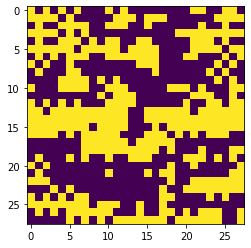

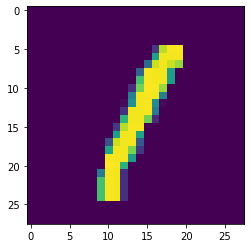

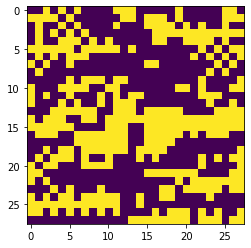

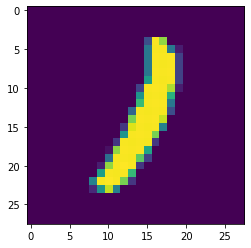

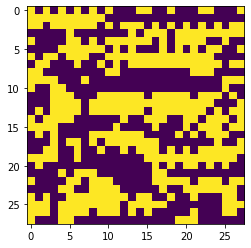

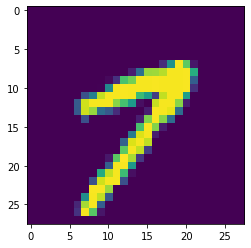

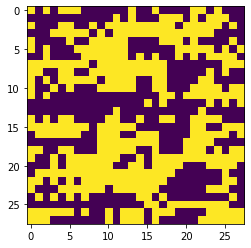

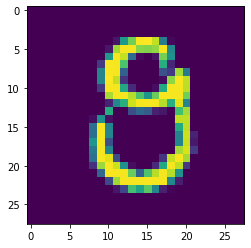

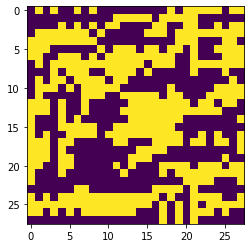

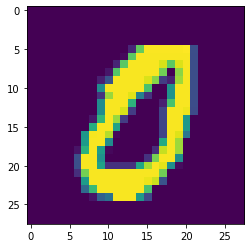

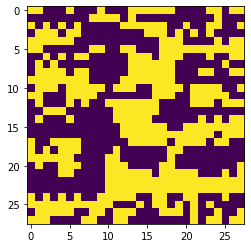

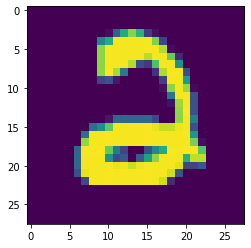

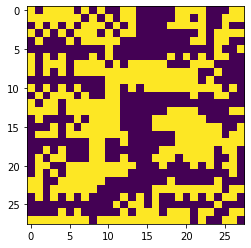

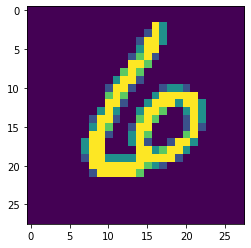

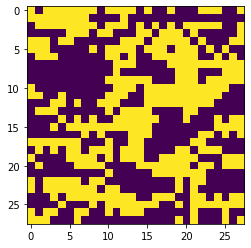

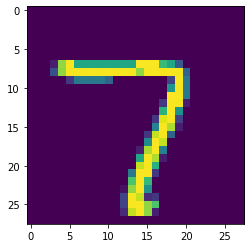

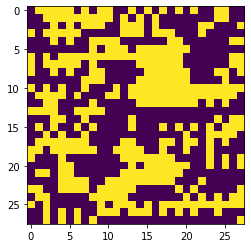

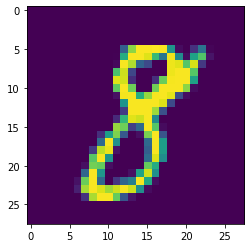

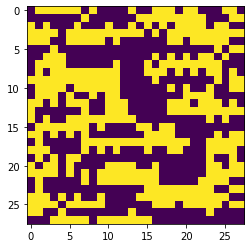

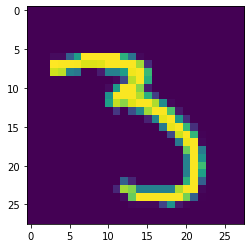

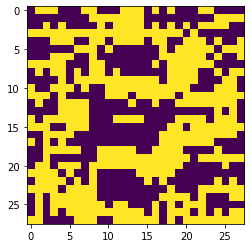

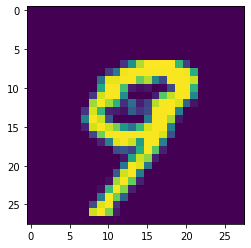

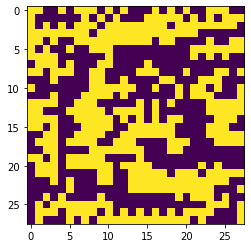

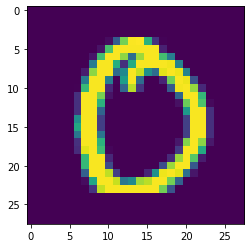

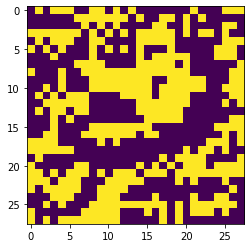

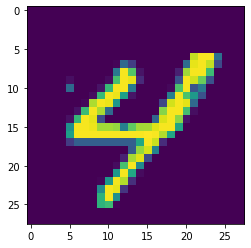

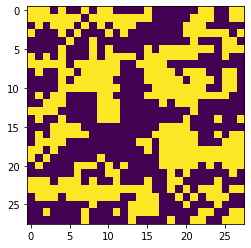

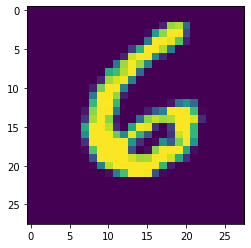

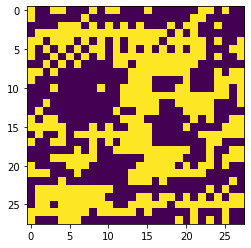

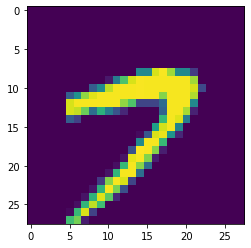

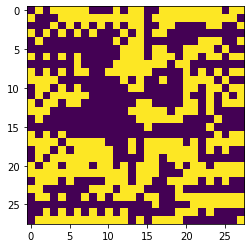

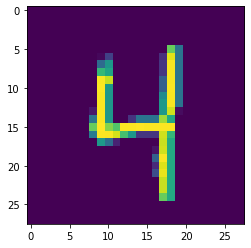

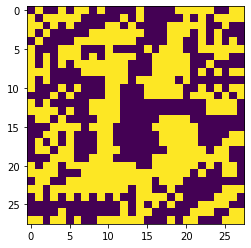

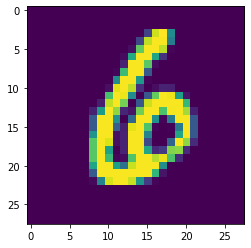

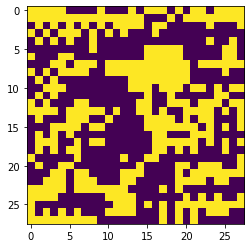

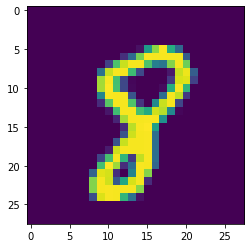

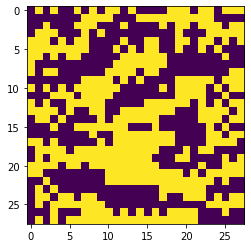

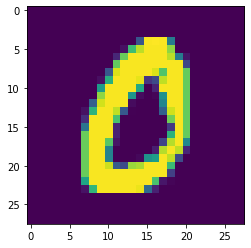

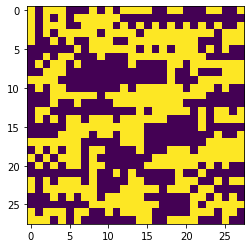

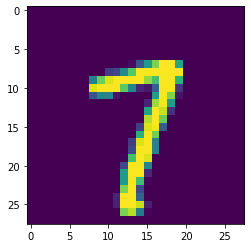

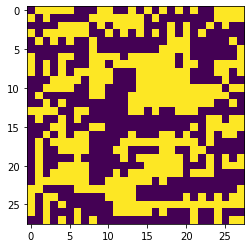

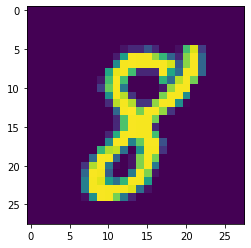

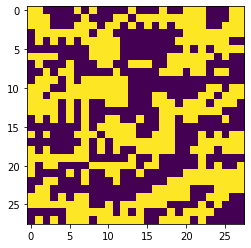

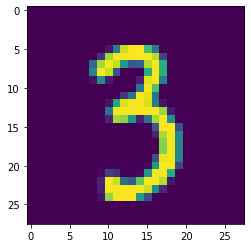

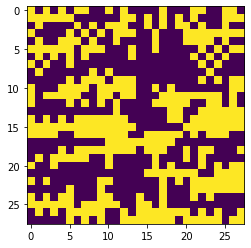

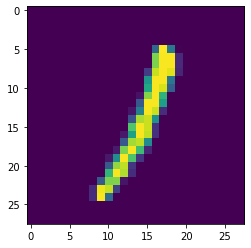

In [27]:
with tf.device('CPU:0'):
    masks = hf.Adversarial.create_adversarial_masks(train_images_tf, 
                                                    train_labels, 
                                                    tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                                                    baseline)
    print(np.sum(masks == 0))
    for i in range(100):
        plt.imshow(np.squeeze(masks[i]))
        plt.show()
        plt.imshow(train_images[i])
        plt.show()

In [23]:
for i in range(100):
    plt.imshow(masks[i])
    plt.show()
    plt.imshow(train_images[i])
    plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run StridedSlice: Dst tensor is not initialized. [Op:StridedSlice] name: strided_slice/